# 🌲🔥 **California Wildfire Damage** 🔥🌲


## **Introduction**

California's dry climate and frequent droughts create a perfect condition for wildfire. These wildfires can spread rapidly and have the possibility of causing great damages: destroyging houses, businesses, vehicles, and even taking lives. Beyond the immediate destruction, wildfire also leads to economic loss and environmental harm. Because of their devastating impact, it is extremely important to understand more about them and be able to anticipate when, where wildfires would happen as well as the magnitude of the fire. This project focuses on classifying what California's counties would be more likely to experience a severe wildfires.

To classify the counties into whether they would have a high risk of having catastrophic wildfires versus low risk, we utilize the public dataset California Wildfire Damage that is available on Kaggle. This dataset provides a complete record of wildfire incidents that happened in California over the past 10 years. It consists of a lot of crucial variables that are highly needed for this project: Date, Location, Area affected by wildfires, Homes destroyed, Businesses destroyed, Vehicles damaged, Injuries, Fatalities, Financial Loss, and Cause. 

## Import libraries

In [1082]:
# Importing datasets
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import kagglehub
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os
import geopandas as gpd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Import dataset

For this project, we will use 2 datasets

| Dataset                              | Description                                    | Key Features                                                                                                    |
| ------------------------------------ | ---------------------------------------------- | --------------------------------------------------------------------------------------------------------------- |
| **California\_Wildfire\_Damage.csv** | Records of wildfires in California (2014–2024) | County, Acres Burned, Homes/Businesses Destroyed, Vehicles Damaged, Injuries, Fatalities, Financial Loss, Cause |
| **CA\_Counties.shp**                 | Geospatial shapefile of California counties    | County boundaries for mapping and spatial analysis                                                              |


In [1083]:

county_path = kagglehub.dataset_download("kylescissons/california-county-boundaries")

print("Path tp dataset files:", county_path)

Path tp dataset files: /Users/baotruong/.cache/kagglehub/datasets/kylescissons/california-county-boundaries/versions/1


In [1084]:

for filename in os.listdir(county_path):
    print(filename)

CA_Counties.cpg
CA_Counties.shp
CA_Counties.shx
CA_Counties.sbx
CA_Counties.shp.xml
CA_Counties.dbf
CA_Counties.prj
CA_Counties.sbn


In [1085]:
df = pd.read_csv("../data/California Wildfire Damage.csv")
#shp_file = os.path.join(county_path, "CA_Counties.shp")
Counties = gpd.read_file("../data/archive (1)")

## Exploratory Data Analysis

In [1086]:
print(df.shape)
print(df.info())
print(df.describe(include = 'all'))
print(df.isnull().sum())

(100, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Incident_ID                           100 non-null    object 
 1   Date                                  100 non-null    object 
 2   Location                              100 non-null    object 
 3   Area_Burned (Acres)                   100 non-null    int64  
 4   Homes_Destroyed                       100 non-null    int64  
 5   Businesses_Destroyed                  100 non-null    int64  
 6   Vehicles_Damaged                      100 non-null    int64  
 7   Injuries                              100 non-null    int64  
 8   Fatalities                            100 non-null    int64  
 9   Estimated_Financial_Loss (Million $)  100 non-null    float64
 10  Cause                                 100 non-null    object 
dtypes: float64

In [1087]:
# Renaming the variables
dic = {"Area_Burned (Acres)":"Area_Burned", "Estimated_Financial_Loss (Million $)": "Financial_Loss"}
df = df.rename(columns = dic)
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

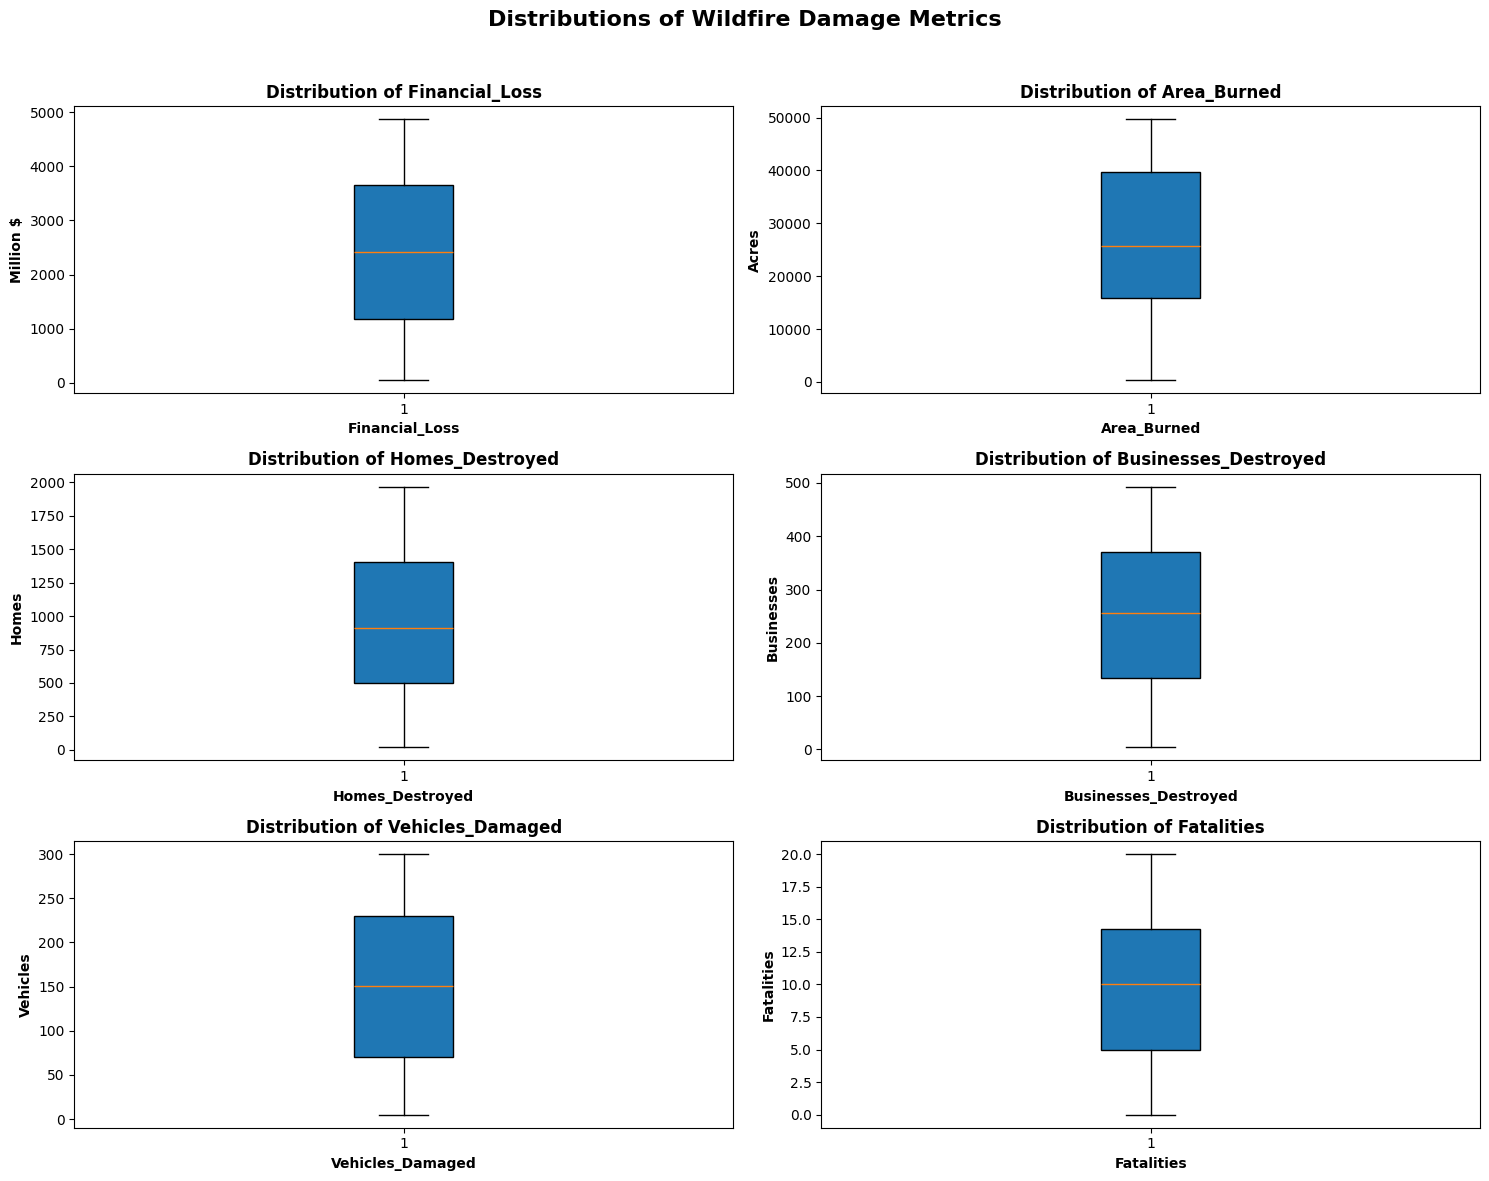

In [1088]:
# Visualize the distribution of the variables
cols = ["Financial_Loss", "Area_Burned", "Homes_Destroyed", 
        "Businesses_Destroyed", "Vehicles_Damaged", "Fatalities"]
y_labels = ["Million $", "Acres", "Homes",
            "Businesses", "Vehicles", "Fatalities"]
fig, ax = plt.subplots(3, 2, figsize=(15, 12))
ax = ax.flatten()

for i, col in enumerate(cols):
    ax[i].boxplot(df[col].dropna(), vert=True, patch_artist=True)
    ax[i].set_title(f"Distribution of {col}", fontsize=12, weight="bold")
    ax[i].set_xlabel(col, fontsize = 10, weight = "bold")
    ax[i].set_ylabel(y_labels[i], fontsize = 10, weight = "bold")

plt.suptitle("Distributions of Wildfire Damage Metrics", fontsize=16, weight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

<span style="font-size: 20px;">Overall, we see that all the variables (Financial Loss, Area Burned, Homes Destroyed, Businesses Destroyed, Vehicles Damaged, Fatalities) are approximately normally distributed. That means we can apply clustering without data transformation.</span>

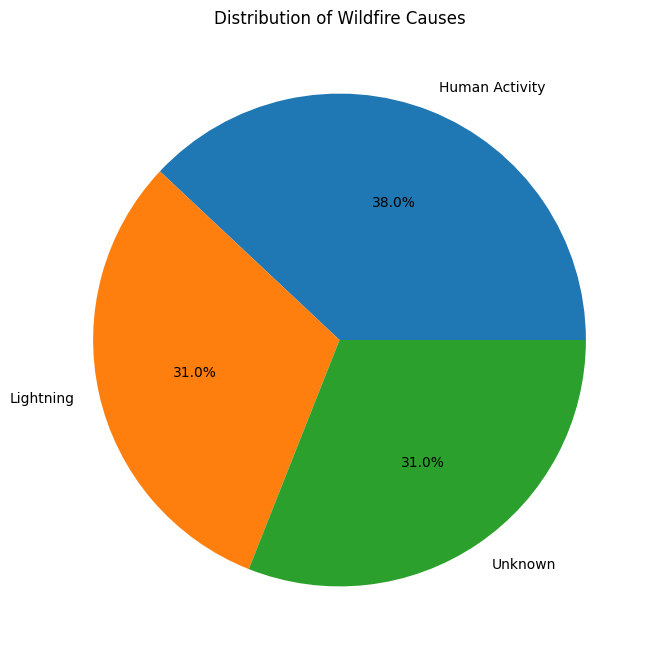

In [1089]:
# Visualize the percentage of Cause
cause_counts = df.groupby('Cause').agg(count=('Date', 'count')).reset_index()
plt.figure(figsize = (10,8))
plt.pie(cause_counts['count'], labels=cause_counts['Cause'], autopct='%1.1f%%')
plt.title("Distribution of Wildfire Causes")
plt.show()

<span style="font-size: 20px;">We see that the distribution for causes are approximately equal. The highest percentage of cost is Human Activity. This includes arson, burning debris, etc. Coming in second are Lightning and Unknown causes. One way that we can prevent more wildfires is to raise public awareness about activities that can cause fire.</span>

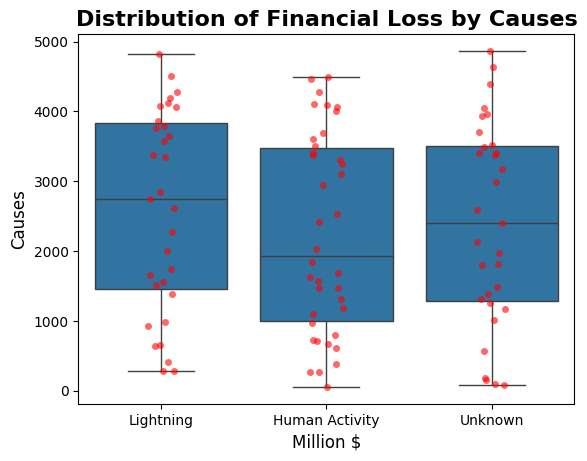

In [1090]:
# Visualize the damage of each cost
sns.boxplot(x="Cause", y="Financial_Loss", data=df)
sns.stripplot(x="Cause", y="Financial_Loss", data=df, 
               color="red", alpha=0.6)
plt.xlabel("Million $", fontsize = 12)
plt.ylabel("Causes", fontsize = 12)
plt.title("Distribution of Financial Loss by Causes", fontsize = 16, weight = "bold")
plt.show()

<span style="font-size: 20px;">One important things that we notice on this graph is that despite causing the most wildfires, Human Activity Cause has a lower min, median, and max Financial Damage. On the other hand, Lightning's distribution of Financial Loss seems to be a little bit higher than the other 2. This might be explained that Human Activity has a smaller magnitude than Lightning, therefore creates less financial damage.</span>

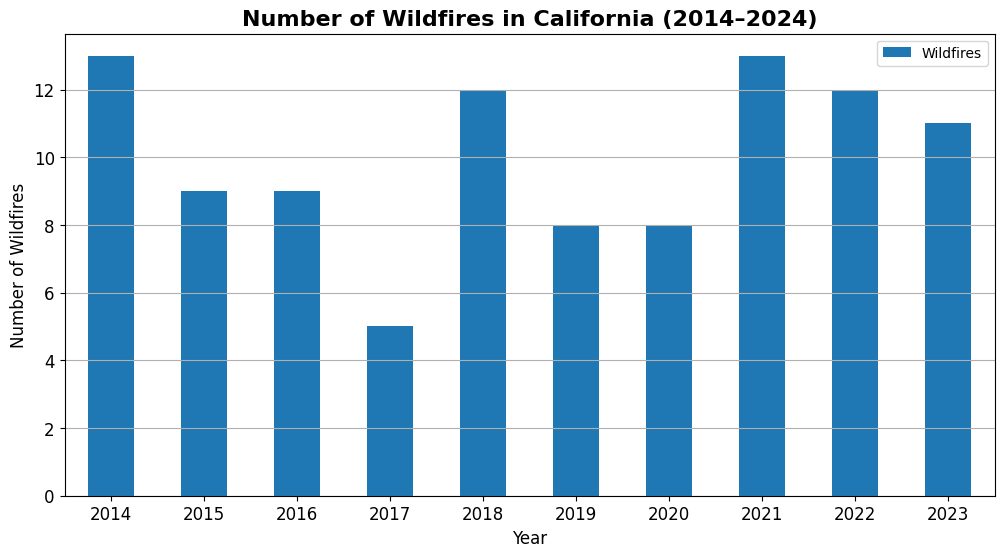

In [1091]:
# Number of wildfires by Year
df.groupby('Year').agg(Wildfires = ('Date', 'count')).plot(kind = 'bar', figsize = (12,6))
plt.xticks(rotation = 0, fontsize = 12)
plt.yticks(fontsize = 12)
plt.title("Number of Wildfires in California (2014–2024)", fontsize=16, weight="bold")
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Wildfires", fontsize=12)
plt.grid(axis = "y")
plt.show()

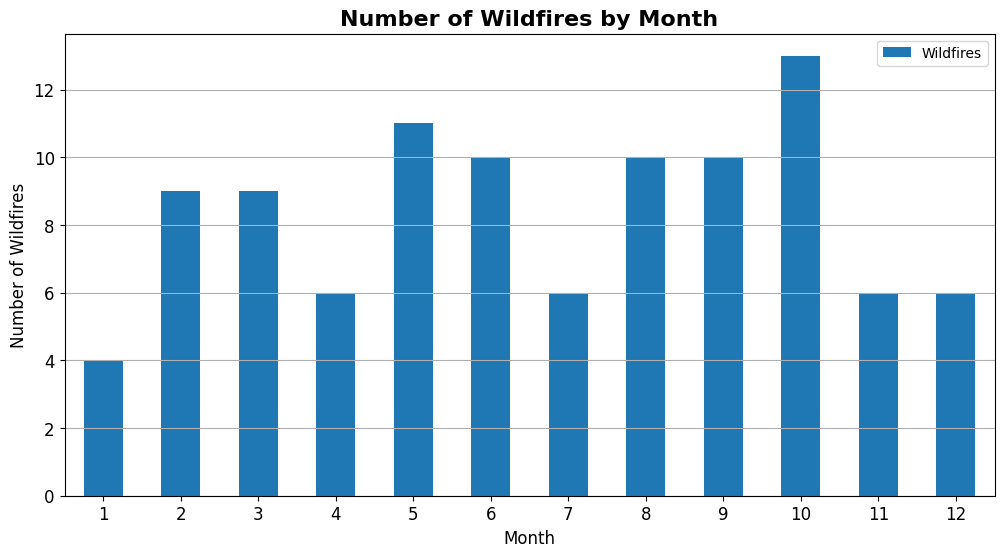

In [1092]:
# Number of wildfires by Month
df.groupby('Month').agg(Wildfires = ('Date', 'count')).plot(kind = 'bar', figsize = (12,6))
plt.xticks(rotation = 0, fontsize = 12)
plt.yticks(fontsize = 12)
plt.title("Number of Wildfires by Month", fontsize=16, weight="bold")
plt.xlabel("Month", fontsize=12)
plt.ylabel("Number of Wildfires", fontsize=12)
plt.grid(axis = "y")
plt.show()

<span style="font-size: 20px;">Throughout 10 years, we see that the number of wildfires fluctuates and peaks in 2014, 2018, and 2021. This shows no trend at all. However, for the Month graphs, we see that the months with highest wildfires are May, June, August, September, October. This aligns with the Summer and Fall season with the exception of July. This phenomennon indicates that the dry and windy climate creates more wildfires.</span>

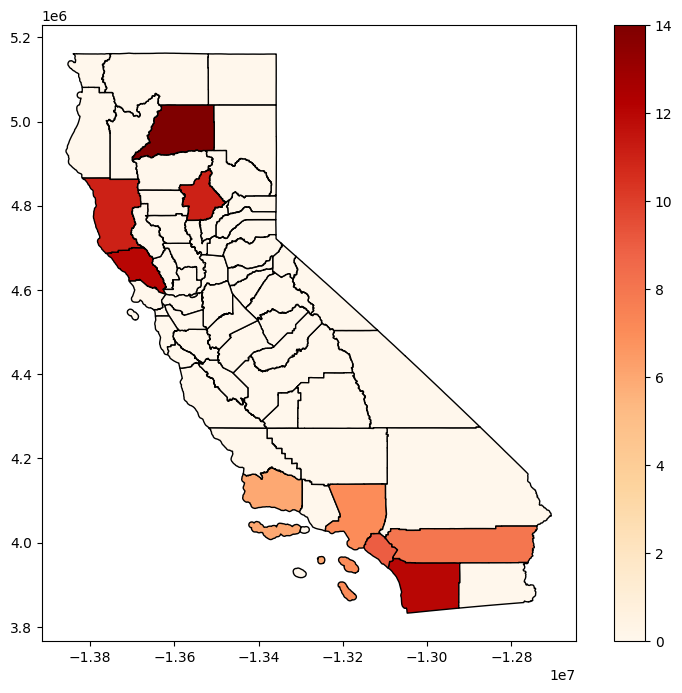

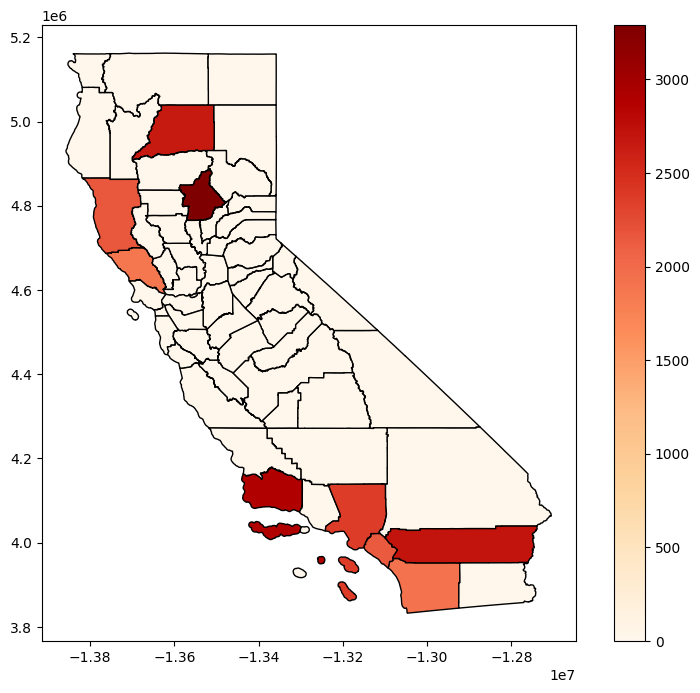

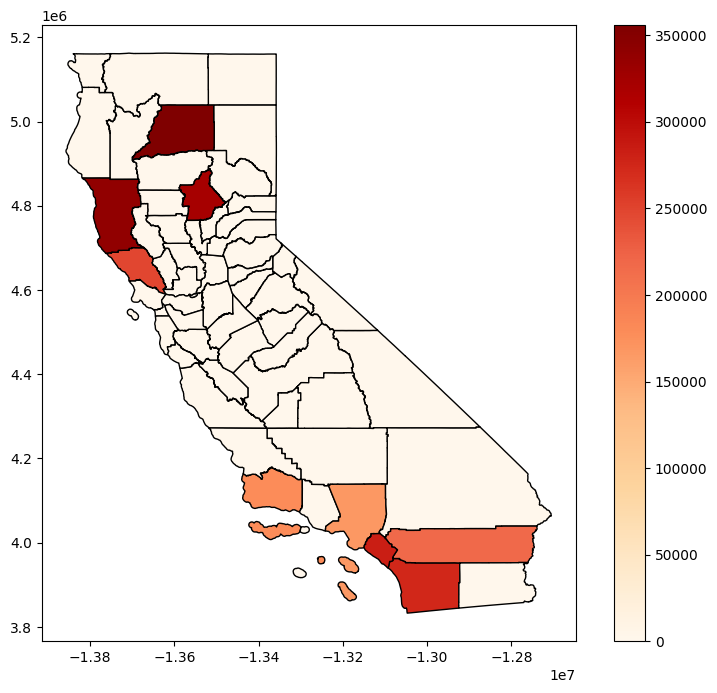

In [1093]:
# Number of wildfire incidents happened in each county during the period 2014 - 2024
wildfire_counts = df.groupby('Location').agg(Wildfire_Count = ('Date', 'count'))
Counties_count = Counties.merge(wildfire_counts, left_on = 'NAMELSAD', right_on = 'Location', how = "left")
Counties_count['Wildfire_Count'] = Counties_count['Wildfire_Count'].fillna(0)

fig,ax = plt.subplots(figsize = (10,8))
Counties_count.plot(column="Wildfire_Count",
                cmap = 'OrRd',
                legend= True,
                edgecolor= 'black',
                ax = ax)

wildfire_damage = df.groupby('Location').agg(Wildfire_Damage = ('Financial_Loss', 'mean'))
Counties_damage = Counties.merge(wildfire_damage, left_on = 'NAMELSAD', right_on = 'Location', how = "left")
Counties_damage['Wildfire_Damage'] = Counties_damage['Wildfire_Damage'].fillna(0)

fig,ax = plt.subplots(figsize = (10,8))
Counties_damage.plot(column="Wildfire_Damage",
                cmap = 'OrRd',
                legend= True,
                edgecolor= 'black',
                ax = ax)

area_burned = df.groupby('Location').agg(Area = ('Area_Burned','sum'))
Counties_area = Counties.merge(area_burned, left_on = 'NAMELSAD', right_on = 'Location', how = "left")
Counties_area['Area'] = Counties_area['Area'].fillna(0)

fig,ax = plt.subplots(figsize = (10,8))
Counties_area.plot(column="Area",
                cmap = 'OrRd',
                legend= True,
                edgecolor= 'black',
                ax = ax)
plt.show()

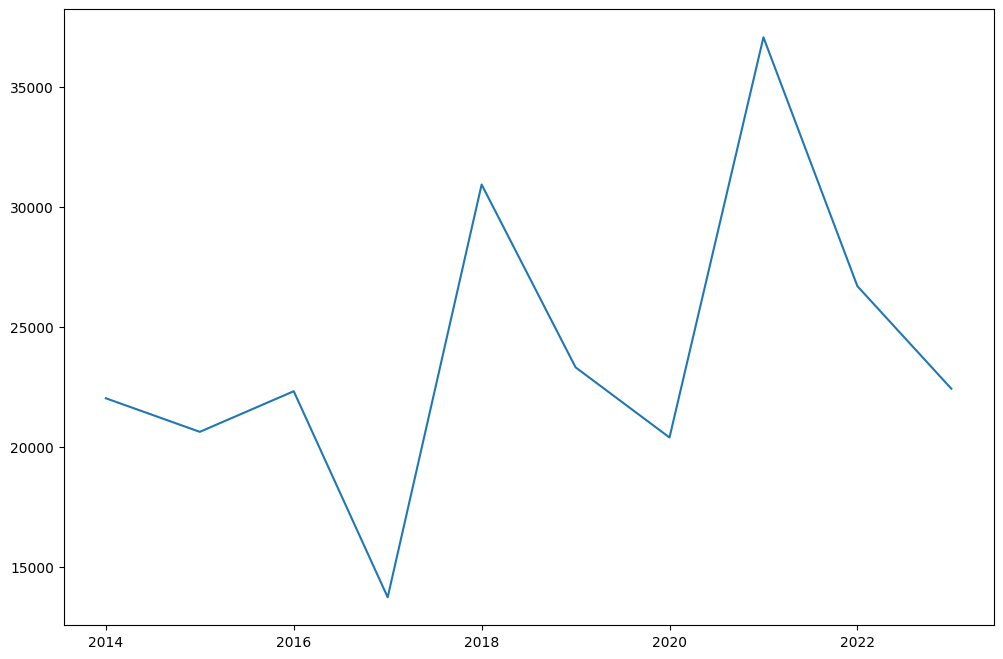

In [1094]:
plt.figure(figsize = (12,8))
total_sum = df.groupby('Year').agg(sum = ('Financial_Loss', 'sum')).reset_index()
plt.plot(total_sum['Year'], total_sum['sum'])

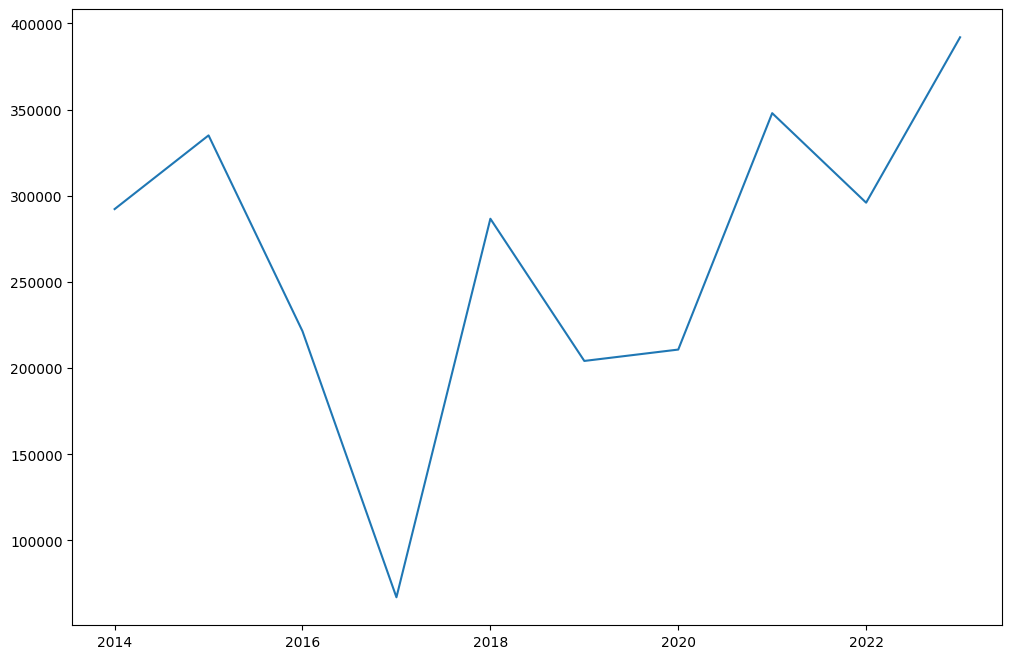

In [1095]:
plt.figure(figsize = (12,8))
total_area = df.groupby('Year').agg(sum = ('Area_Burned', 'sum')).reset_index()
plt.plot(total_area['Year'], total_area['sum'])
plt.show()

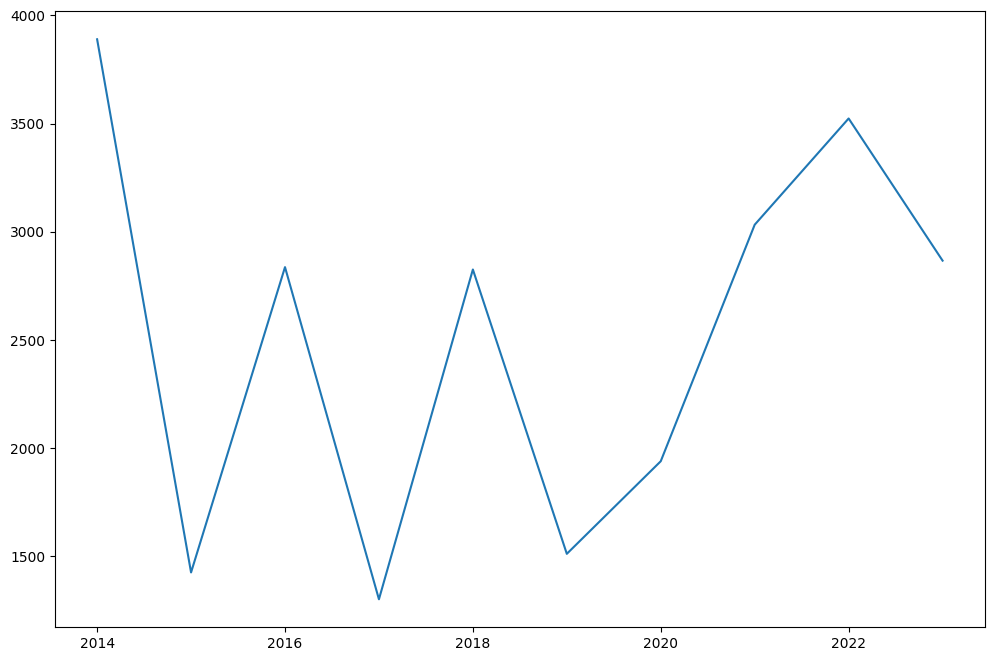

In [1096]:
plt.figure(figsize = (12,8))
total_area = df.groupby('Year').agg(sum = ('Businesses_Destroyed', 'sum')).reset_index()
plt.plot(total_area['Year'], total_area['sum'])
plt.show()

<Axes: xlabel='Location'>

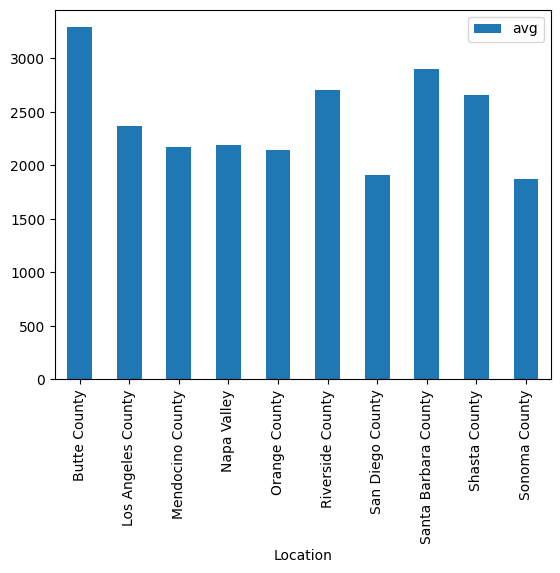

In [1097]:
data = df.groupby('Location').agg(avg = ('Financial_Loss', 'mean'))
data.plot(kind = 'bar')

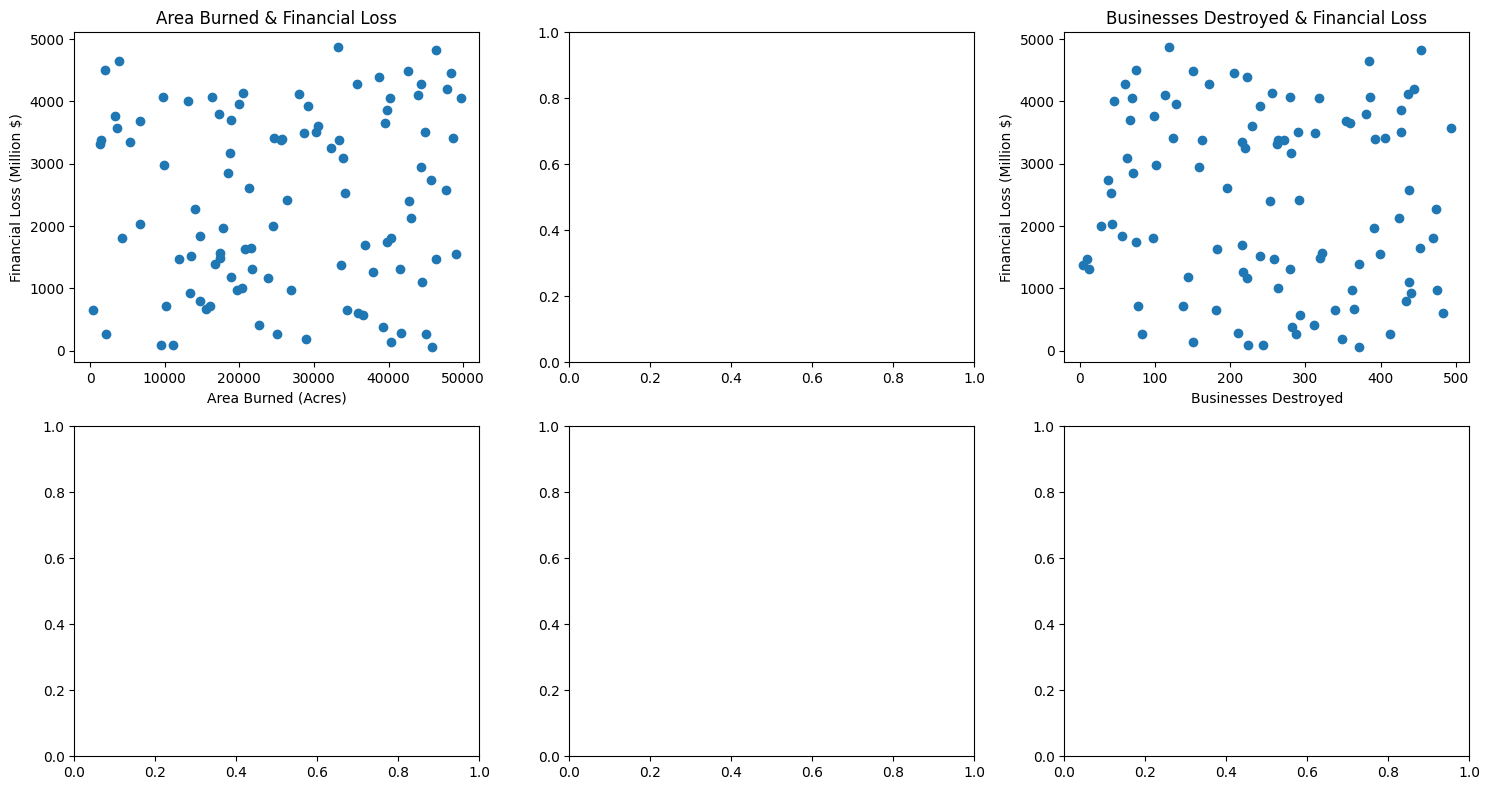

In [1098]:
fig, ax = plt.subplots(2,3, figsize = (15,8))

ax[0,0].scatter(df['Area_Burned'], df['Financial_Loss'])
ax[0,0].set_xlabel("Area Burned (Acres)")
ax[0,0].set_ylabel("Financial Loss (Million $)")
ax[0,0].set_title("Area Burned & Financial Loss")

ax[0,2].scatter(df['Businesses_Destroyed'], df['Financial_Loss'])
ax[0,2].set_xlabel("Businesses Destroyed")
ax[0,2].set_ylabel("Financial Loss (Million $)")
ax[0,2].set_title("Businesses Destroyed & Financial Loss")


plt.tight_layout()
plt.show()

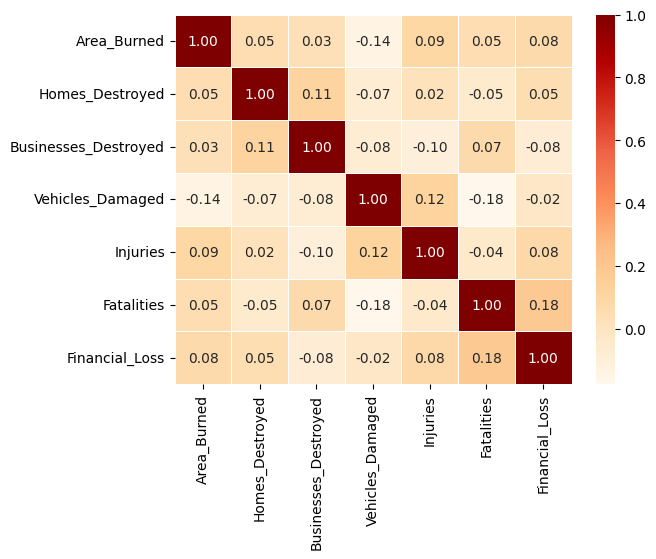

In [1099]:
variables = ['Area_Burned', 'Homes_Destroyed', 'Businesses_Destroyed', 'Vehicles_Damaged', 'Injuries', 'Fatalities', 'Financial_Loss']
corr = df[variables].corr()
sns.heatmap(corr, annot= True, cmap = 'OrRd', fmt = ".2f", linewidths= .5)
plt.show()

In [1100]:
X = df[["Area_Burned", "Financial_Loss", "Vehicles_Damaged", 
        "Homes_Destroyed", "Businesses_Destroyed", 
        "Fatalities", "Injuries"]]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [1101]:
pc = PCA()
pc_scores = pc.fit_transform(X_scaled)
pc_loadings = pc.components_.T
pc_loadings = pd.DataFrame(pc_loadings, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7'],
                           index = ["Area_Burned", "Financial_Loss", "Vehicles_Damaged", 
        "Homes_Destroyed", "Businesses_Destroyed", 
        "Fatalities", "Injuries"])
print(pc_loadings.round(3))
pc_variances = pc.explained_variance_

                        PC1    PC2    PC3    PC4    PC5    PC6    PC7
Area_Burned          -0.364  0.275  0.385  0.603  0.093 -0.465  0.232
Financial_Loss       -0.312  0.544 -0.133 -0.479 -0.119 -0.403 -0.428
Vehicles_Damaged      0.570  0.162  0.055 -0.331  0.387 -0.434  0.446
Homes_Destroyed      -0.225 -0.109  0.668 -0.481 -0.363  0.134  0.332
Businesses_Destroyed -0.298 -0.480  0.242 -0.190  0.681 -0.124 -0.327
Fatalities           -0.531  0.148 -0.441 -0.162  0.300  0.268  0.560
Injuries              0.153  0.581  0.364  0.049  0.378  0.572 -0.184


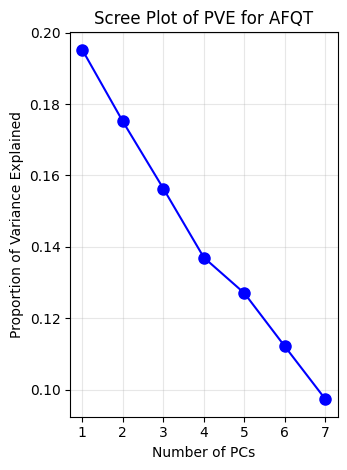

In [1102]:
plt.subplot(1, 2, 2)
plt.plot(range(1, 8), pc.explained_variance_ratio_, 'bo-', markersize=8)
plt.xlabel('Number of PCs')
plt.ylabel('Proportion of Variance Explained')
plt.title('Scree Plot of PVE for AFQT')
plt.xticks(range(1, 8))
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [1103]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
df["Cluster"] = kmeans.fit_predict(X_scaled)

In [1104]:
df.groupby("Cluster")[["Area_Burned", "Financial_Loss", "Vehicles_Damaged", 
        "Homes_Destroyed", "Businesses_Destroyed", 
        "Fatalities", "Injuries"]].mean()

,Area_Burned,Financial_Loss,Vehicles_Damaged,Homes_Destroyed,Businesses_Destroyed,Fatalities,Injuries
Cluster,,,,,,,
0,21277.066667,1655.920667,152.300,1185.766667,292.900000,6.000000,23.833333
1,34320.000000,2552.134750,86.925,810.150000,262.975000,13.700000,40.525000
2,21401.133333,2928.230667,232.900,873.666667,195.033333,8.833333,62.266667


In [1105]:
county_severity = df.groupby(["Location", "Cluster"]).size().unstack(fill_value=0)
county_severity["Severe_Fire_Rate"] = np.round(county_severity[2] / county_severity.sum(axis=1),2)
county_severity.sort_values("Severe_Fire_Rate", ascending=False)

Cluster,0,1,2,Severe_Fire_Rate
Location,,,,
Butte County,2,3,6,0.55
Santa Barbara County,0,3,3,0.50
Los Angeles County,2,2,3,0.43
Shasta County,3,5,6,0.43
Sonoma County,5,3,4,0.33
Mendocino County,2,6,3,0.27
Napa Valley,4,4,2,0.20
San Diego County,6,4,2,0.17
Orange County,1,7,1,0.11


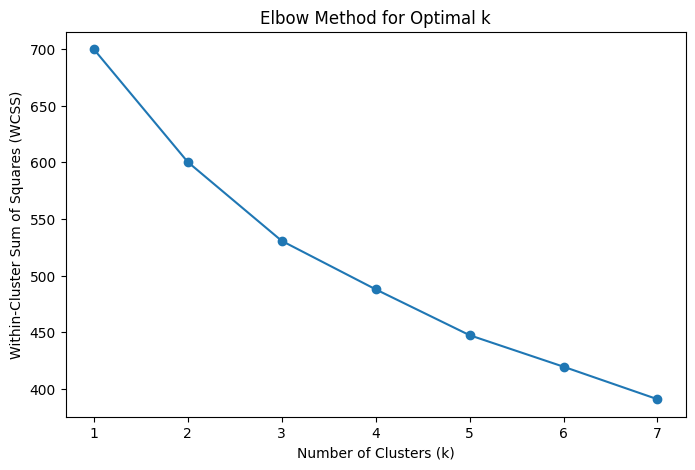

In [1106]:
wcss = []  # Within-cluster sum of squares

# Try k from 1 to 10
for k in range(1, 8):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 8), wcss, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.title("Elbow Method for Optimal k")
plt.show()